In [28]:
import requests
from bs4 import BeautifulSoup
import re
import pandas as pd
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv("태양광_테스트_데이터.csv")

month_list = [
    'january',
    'february',
    'march',
    'april',
    'may',
    'june',
    'july',
    'august',
    'september',
    'october',
    'november',
    'december'
]
year = datetime.today().year

for month_index in range(len(month_list)):
    html = requests.get("https://www.accuweather.com/ko/kr/boseong-gun/224269/daily-weather-forecast/224269?day=1", headers={"User-Agent" : "Mozilla/5.0"}).text

    soup = BeautifulSoup(html, "html.parser")
    monthly_daypanel_list = soup.find_all("a", {"class":"monthly-daypanel"})

    num = re.compile('[^0-9+]')
    
    for monthly_daypanel in monthly_daypanel_list:
        monthly_daypanel_str = str(monthly_daypanel)
        if "icon-container" in monthly_daypanel_str:
            date_data = num.sub('', str(monthly_daypanel.find("div", {"class":"date"})))
            date = f'{month_index+1}-{date_data}'
            high = num.sub('', str(monthly_daypanel.find("div", {"class":"high"})))
            low = num.sub('', str(monthly_daypanel.find("div", {"class":"low"})))
            df = df.append({'일자':date, '최저기온(°C)':low, '최고기온(°C)':high}, ignore_index=True)
    
df[:30]

,일자,최저기온(°C),최고기온(°C)
0,8-12,23,34
1,8-13,26,33
2,8-14,24,32
3,8-15,25,31
4,8-16,24,30
5,8-17,21,31
6,8-18,23,32
7,8-19,24,31
8,8-20,23,32
9,8-21,22,30


In [7]:
df = pd.read_csv("태양광_테스트_데이터.csv")
df

,일자,최저기온(°C),최고기온(°C),일강수량(mm),평균 풍속(m/s),평균 전운량(1/10)


In [2]:
import numpy as np
from flask import Flask, render_template
from flask import request
from lightgbm import LGBMRegressor
import requests
from bs4 import BeautifulSoup
import re
import pandas as pd
import datetime
from datetime import timedelta, datetime
import warnings
warnings.filterwarnings('ignore')

input_area = "boseong-gun"
input_start_date = "2022-09-16"
input_end_date = "2022-10-10"

today = datetime.now()
start_day = datetime.strptime(input_start_date, "%Y-%m-%d")
end_day = datetime.strptime(input_end_date, "%Y-%m-%d")

today_diff = int((start_day - today).days)
date_diff = int((end_day - start_day).days)

df_data = {}
num = re.compile('[^0-9+]')
df = pd.read_csv("태양광_테스트_데이터.csv")

for i in range(date_diff+1):
    next_day = start_day + timedelta(days=i)

    df_data['일자'] = str(next_day.date())

    html = requests.get(f"https://www.accuweather.com/ko/kr/{input_area}/224269/daily-weather-forecast/224269?day={today_diff+i+2}", headers={"User-Agent" : "Mozilla/5.0"}).text
    soup = BeautifulSoup(html, "html.parser")

    temperature_list = soup.find_all("div", {"class":"temperature"})
    for temperature in temperature_list:
        if "최고" in str(temperature):
            high = num.sub('', str(temperature))
            df_data['최고기온(°C)'] = float(high)
        if "최저" in str(temperature):
            low = num.sub('', str(temperature))
            df_data['최저기온(°C)'] = float(low)
            break

    panel_item_list = soup.find_all("p", {"class":"panel-item"})
    for panel_item in panel_item_list:
        if ">강수<" in str(panel_item):
            precipitation = num.sub('', str(panel_item))
            df_data['일강수량(mm)'] = float(precipitation)/10
        if "바람" in str(panel_item):
            wind = num.sub('', str(panel_item))
            df_data['평균 풍속(m/s)'] = float(wind)
        if "구름량" in str(panel_item):
            cloud = num.sub('', str(panel_item))
            df_data['평균 전운량(1/10)'] = float(cloud)/10
            break

    df = df.append(df_data, ignore_index=True)

df

FileNotFoundError: [Errno 2] No such file or directory: '태양광_테스트_데이터.csv'

In [3]:
photovoltaics_df = pd.read_csv('태양광_데이터.csv')
X = photovoltaics_df[[
    '최저기온(°C)',
    '최고기온(°C)',
    '일강수량(mm)',
    '평균 풍속(m/s)',
    '평균 전운량(1/10)'
]]
y = photovoltaics_df['발전량']

print(X.info())

photovoltaics_model = LGBMRegressor(max_depth=2, min_samples_leaf=2, min_samples_split=2, n_estimators=100)

photovoltaics_model.fit(X, y)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 943 entries, 0 to 942
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   최저기온(°C)      943 non-null    float64
 1   최고기온(°C)      943 non-null    float64
 2   일강수량(mm)      302 non-null    float64
 3   평균 풍속(m/s)    942 non-null    float64
 4   평균 전운량(1/10)  941 non-null    float64
dtypes: float64(5)
memory usage: 37.0 KB
None
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=2. Current value: min_data_in_leaf=2
[LightGBM] [Warning] Unknown parameter: min_samples_split


LGBMRegressor(max_depth=2, min_samples_leaf=2, min_samples_split=2)

In [3]:
X_test = df[[
    '최저기온(°C)',
    '최고기온(°C)',
    '일강수량(mm)',
    '평균 풍속(m/s)',
    '평균 전운량(1/10)'
]]

print(X_test.info())

photovoltaics_predict = photovoltaics_model.predict(X_test)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25 entries, 0 to 24
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   최저기온(°C)      25 non-null     float64
 1   최고기온(°C)      25 non-null     float64
 2   일강수량(mm)      25 non-null     float64
 3   평균 풍속(m/s)    25 non-null     float64
 4   평균 전운량(1/10)  25 non-null     float64
dtypes: float64(5)
memory usage: 1.1 KB
None


In [13]:
y_value = (np.max(photovoltaics_predict) // 100 + 1) * 100
photovoltaics_predict_percent = photovoltaics_predict/y_value *100
photovoltaics_predict_percent = np.asarray(photovoltaics_predict_percent, dtype = int).tolist()
date_list = df['일자'].values.tolist()
mouth_num = len(date_list)
photovoltaics_predict_percent, date_list, mouth_num

([98,
  100,
  76,
  40,
  23,
  28,
  38,
  76,
  100,
  100,
  89,
  85,
  74,
  75,
  46,
  76,
  67,
  98,
  78,
  87,
  42,
  81,
  98,
  98,
  99],
 ['2022-09-16',
  '2022-09-17',
  '2022-09-18',
  '2022-09-19',
  '2022-09-20',
  '2022-09-21',
  '2022-09-22',
  '2022-09-23',
  '2022-09-24',
  '2022-09-25',
  '2022-09-26',
  '2022-09-27',
  '2022-09-28',
  '2022-09-29',
  '2022-09-30',
  '2022-10-01',
  '2022-10-02',
  '2022-10-03',
  '2022-10-04',
  '2022-10-05',
  '2022-10-06',
  '2022-10-07',
  '2022-10-08',
  '2022-10-09',
  '2022-10-10'],
 25)

In [3]:
#월별 데이터 나누기
import numpy as np
from flask import Flask, render_template
from flask import request
from lightgbm import LGBMRegressor
import requests
from bs4 import BeautifulSoup
import re
import pandas as pd
import datetime
from datetime import timedelta, date
import warnings
warnings.filterwarnings('ignore')

########## 머신러닝 ##########

photovoltaics_df = pd.read_csv('태양광_데이터.csv')
X = photovoltaics_df[[
    '최저기온(°C)',
    '최고기온(°C)',
    '일강수량(mm)',
    '평균 풍속(m/s)',
    '평균 전운량(1/10)'
]]
X = X.fillna(0)

y = photovoltaics_df['발전량']

print(X.info())

photovoltaics_model = LGBMRegressor(max_depth=2, min_samples_leaf=2, min_samples_split=2, n_estimators=100)

photovoltaics_model.fit(X, y)

########## 날씨데이터 크롤링 ##########

input_area = "boseong-gun"
input_start_date = "2022-08-16"
input_end_date = "2022-10-10"

today = date.today()
start_date = date.fromisoformat(input_start_date)
end_date = date.fromisoformat(input_end_date)

today_diff = int((start_date - today).days)
date_diff = int((end_date - start_date).days)

df_data = {}
num = re.compile('[^0-9+]')

past_month = start_date.month

for i in range(date_diff+1):
    next_date = start_date + timedelta(days=i)
    if i == 0 or next_date.month != past_month:
        globals()['df_'+str(next_date.month)] = pd.read_csv("태양광_테스트_데이터.csv")
    
    df_data['일자'] = str(next_date)

    html = requests.get(f"https://www.accuweather.com/ko/kr/{input_area}/224269/daily-weather-forecast/224269?day={today_diff+i+1}", headers={"User-Agent" : "Mozilla/5.0"}).text
    soup = BeautifulSoup(html, "html.parser")

    temperature_list = soup.find_all("div", {"class":"temperature"})
    for temperature in temperature_list:
        if "최고" in str(temperature):
            high = num.sub('', str(temperature))
            df_data['최고기온(°C)'] = float(high)
        if "최저" in str(temperature):
            low = num.sub('', str(temperature))
            df_data['최저기온(°C)'] = float(low)
            break

    panel_item_list = soup.find_all("p", {"class":"panel-item"})
    for panel_item in panel_item_list:
        if ">강수<" in str(panel_item):
            precipitation = num.sub('', str(panel_item))
            df_data['일강수량(mm)'] = float(precipitation)/10
        if "바람" in str(panel_item):
            wind = num.sub('', str(panel_item))
            df_data['평균 풍속(m/s)'] = float(wind)
        if "구름량" in str(panel_item):
            cloud = num.sub('', str(panel_item))
            df_data['평균 전운량(1/10)'] = float(cloud)/10
            break
    
    globals()['df_'+str(next_date.month)] = globals()['df_'+str(next_date.month)].append(df_data, ignore_index=True)
    
    if next_date.month != past_month:
        X_test = globals()['df_'+str(next_date.month - 1)][[
            '최저기온(°C)',
            '최고기온(°C)',
            '일강수량(mm)',
            '평균 풍속(m/s)',
            '평균 전운량(1/10)'
        ]]

        globals()['predict_'+str(next_date.month - 1)] = photovoltaics_model.predict(X_test)
        
    if i == date_diff:
        X_test = globals()['df_'+str(next_date.month)][[
            '최저기온(°C)',
            '최고기온(°C)',
            '일강수량(mm)',
            '평균 풍속(m/s)',
            '평균 전운량(1/10)'
        ]]

        globals()['predict_'+str(next_date.month)] = photovoltaics_model.predict(X_test)
    
    past_month = next_date.month

df_8, df_9, df_10, predict_8, predict_9, predict_10

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 943 entries, 0 to 942
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   최저기온(°C)      943 non-null    float64
 1   최고기온(°C)      943 non-null    float64
 2   일강수량(mm)      943 non-null    float64
 3   평균 풍속(m/s)    943 non-null    float64
 4   평균 전운량(1/10)  943 non-null    float64
dtypes: float64(5)
memory usage: 37.0 KB
None


(            일자  최저기온(°C)  최고기온(°C)  일강수량(mm)  평균 풍속(m/s)  평균 전운량(1/10)
 0   2022-08-16      21.0      31.0       6.3        20.0          10.0
 1   2022-08-17      21.0      31.0       0.0         6.0           7.5
 2   2022-08-18      25.0      31.0       6.5         4.0           6.0
 3   2022-08-19      26.0      31.0       3.5        13.0          10.0
 4   2022-08-20      23.0      32.0       0.0         9.0           4.3
 5   2022-08-21      26.0      30.0       0.0        11.0           8.2
 6   2022-08-22      27.0      31.0       3.5        11.0           9.1
 7   2022-08-23      22.0      30.0       0.0         7.0           8.9
 8   2022-08-24      22.0      30.0       0.0         6.0           9.2
 9   2022-08-25      22.0      30.0       1.4        19.0           9.6
 10  2022-08-26      22.0      29.0       2.4        15.0           9.0
 11  2022-08-27      23.0      29.0       0.0         9.0           2.7
 12  2022-08-28      23.0      29.0       0.0         7.0       

In [1]:
# 매달 일수
import numpy as np
from flask import Flask, render_template
from flask import request
from lightgbm import LGBMRegressor
import requests
from bs4 import BeautifulSoup
import re
import pandas as pd
import datetime
from datetime import timedelta, date
import warnings
import joblib
warnings.filterwarnings('ignore')

input_area = '224269'
input_start_date = "2022-08-23"
input_end_date = "2022-08-23"

today = date.today()
start_date = date.fromisoformat(input_start_date)
start_month = start_date.month
end_date = date.fromisoformat(input_end_date)

today_diff = int((start_date - today).days)
date_diff = int((end_date - start_date).days)

df_data = {}
month_change = []
num = re.compile('[^0-9+]')
df = pd.read_csv("month_data/month_columns.csv")

past_month = start_date.month

for i in range(date_diff+1):
    next_date = start_date + timedelta(days=i)

    df_data['일자'] = str(next_date)

    html = requests.get(f"https://www.accuweather.com/ko/kr/boseong-gun/224269/daily-weather-forecast/{input_area}?day={today_diff+i+1}", headers={"User-Agent" : "Mozilla/5.0"}).text
    soup = BeautifulSoup(html, "html.parser")

    temperature_list = soup.find_all("div", {"class":"temperature"})
    for temperature in temperature_list:
        if "최고" in str(temperature):
            high = num.sub('', str(temperature))
            df_data['최고기온(°C)'] = float(high)
        if "최저" in str(temperature):
            low = num.sub('', str(temperature))
            df_data['최저기온(°C)'] = float(low)
            break

    panel_item_list = soup.find_all("p", {"class":"panel-item"})
    for panel_item in panel_item_list:
        if ">강수<" in str(panel_item):
            precipitation = num.sub('', str(panel_item))
            df_data['일강수량(mm)'] = float(precipitation)/10
        if "바람" in str(panel_item):
            wind = num.sub('', str(panel_item))
            df_data['평균 풍속(m/s)'] = float(wind)
        if "구름량" in str(panel_item):
            cloud = num.sub('', str(panel_item))
            df_data['평균 전운량(1/10)'] = float(cloud)/10
            break

    df = df.append(df_data, ignore_index=True)
    if next_date.month != past_month:
        month_change.append(i-1)
    past_month = next_date.month
month_change.append(date_diff)

smp_df = pd.DataFrame()
smp_df['temp_max'] = df['최고기온(°C)'].values
smp_df['temp_min'] = df['최저기온(°C)'].values
smp_df['temp_mean'] = [smp_df['temp_max'].to_list()[i] + smp_df['temp_min'].to_list()[i] / 2 for i in range(len(smp_df['temp_max'].to_list()))]
smp_df['month'] = pd.to_datetime(df['일자']).dt.month
smp_df['dayofweek'] = pd.to_datetime(df['일자']).dt.dayofweek
supply_model = joblib.load('smp_data/supply_model.pkl')
smp_df['supply'] = supply_model.predict(smp_df)
smp_df['weekofyear'] = pd.to_datetime(df['일자']).dt.weekofyear
smp_df = smp_df.drop(columns='month')

df['일자'] = pd.to_datetime(df['일자']).dt.day

smp_model = joblib.load('smp_data/smp_model.pkl')
smp_predict = smp_model.predict(smp_df)

smp_predict, df

(array([132.03168], dtype=float32),
    일자  최저기온(°C)  최고기온(°C)  일강수량(mm)  평균 풍속(m/s)  평균 전운량(1/10) 뇌우 확률
 0  23      24.0      31.0       0.0         9.0           9.9   NaN)

In [27]:
# 매달 일수
import numpy as np
from flask import Flask, render_template
from flask import request
from lightgbm import LGBMRegressor
import requests
from bs4 import BeautifulSoup
import re
import pandas as pd
import datetime
from datetime import timedelta, date
import warnings
warnings.filterwarnings('ignore')

input_area = "boseong-gun"
input_start_date = "2022-08-16"
input_end_date = "2022-10-10"

today = date.today()
start_date = date.fromisoformat(input_start_date)
end_date = date.fromisoformat(input_end_date)

today_diff = int((start_date - today).days)
date_diff = int((end_date - start_date).days)

df_data = {}
month_change = []
num = re.compile('[^0-9+]')
df = pd.read_csv("month_data/month_columns.csv")

past_month = start_date.month

for i in range(date_diff+1):
    next_date = start_date + timedelta(days=i)

    df_data['일자'] = str(next_date.day)

    html = requests.get(f"https://www.accuweather.com/ko/kr/{input_area}/224269/daily-weather-forecast/224269?day={today_diff+i+1}", headers={"User-Agent" : "Mozilla/5.0"}).text
    soup = BeautifulSoup(html, "html.parser")

    temperature_list = soup.find_all("div", {"class":"temperature"})
    for temperature in temperature_list:
        if "최고" in str(temperature):
            high = num.sub('', str(temperature))
            df_data['최고기온(°C)'] = float(high)
        if "최저" in str(temperature):
            low = num.sub('', str(temperature))
            df_data['최저기온(°C)'] = float(low)
            break

    panel_item_list = soup.find_all("p", {"class":"panel-item"})
    for panel_item in panel_item_list:
        if ">강수<" in str(panel_item):
            precipitation = num.sub('', str(panel_item))
            df_data['일강수량(mm)'] = float(precipitation)/10
        if "바람" in str(panel_item):
            wind = num.sub('', str(panel_item))
            df_data['평균 풍속(m/s)'] = float(wind)
        if "구름량" in str(panel_item):
            cloud = num.sub('', str(panel_item))
            df_data['평균 전운량(1/10)'] = float(cloud)/10
            break

    df = df.append(df_data, ignore_index=True)
    if next_date.month != past_month:
        month_change.append(i-1)
    past_month = next_date.month
month_change.append(date_diff)


df, date_diff, month_change

27
([23.0, 27.0, 60.0, 33.0, 41.0, 37.0, 67.0, 63.0, 60.0, 45.0, 68.0, 30.0, 76.0, 73.0, 72.0, 41.0, 52.0, 17.0, 58.0, 32.0, 67.0, 51.0, 41.0, 52.0, 84.0, 63.0, 91.0, 89.0, 89.0, 76.0, 73.0, 80.0],)


In [71]:
# 시간별 날씨
import numpy as np
from flask import Flask, render_template
from flask import request
from lightgbm import LGBMRegressor
import requests
from bs4 import BeautifulSoup
import re
import pandas as pd
import datetime
from datetime import timedelta, date, datetime
import warnings
warnings.filterwarnings('ignore')

input_area = "224269"

num = re.compile('[^0-9+]')
df = pd.read_csv("day_data/day_columns.csv", encoding="utf-8-sig")
html_accu = requests.get(f"https://www.accuweather.com/ko/kr/boseong-gun/224269/hourly-weather-forecast/{input_area}?day=2", headers={"User-Agent" : "Mozilla/5.0"}).text
soup_accu = BeautifulSoup(html_accu, "html.parser")


for i in range(24):
    data_list = []
    time_weather = soup_accu.find("div", {"id":f"hourlyCard{i}"})
    time_data = time_weather.find("h2", {"class":"date"}).text
    temp_data = int(num.sub('', time_weather.find("div", {"class":"temp metric"}).text))
    precipitation_data = 0.0
    PM_data = 1
    p_list = time_weather.find_all("p")    
    for p in p_list:
        if "강수량" in p:
            precipitation_data = int(num.sub('', p.text))/10
        if "바람" in p:
            wind_data = int(num.sub('', p.text))
        if "습도" in p:
            humidity_data = int(num.sub('', p.text))
        if "구름량" in p:
            cloud_data = int(num.sub('', p.text))/10
        if "대기질" in p and "나쁨" in p:
            PM_data = 0
    data_list.append(time_data)
    data_list.append(temp_data)
    data_list.append(precipitation_data)
    data_list.append(wind_data)
    data_list.append(humidity_data)
    data_list.append(cloud_data)
    data_list.append(PM_data)
    df = df.append(pd.Series(data_list, index=df.columns), ignore_index=True)
df

,일자,기온(°C),강수량(mm),풍속(m/s),습도(%),전운량(10분위),미세먼지
0,오전 12시,25,0.0,7,80,2.1,1
1,오전 1시,25,0.0,7,79,2.4,1
2,오전 2시,25,0.0,7,79,2.7,1
3,오전 3시,25,0.0,7,80,2.9,1
4,오전 4시,24,0.0,6,85,3.7,1
5,오전 5시,25,0.0,6,85,4.5,1
6,오전 6시,25,0.0,4,86,5.3,1
7,오전 7시,25,0.0,6,84,4.7,1
8,오전 8시,26,0.0,6,80,4.1,1
9,오전 9시,27,0.0,7,76,3.5,1


[485, 287, 347, 181, 264, 223, 450, 257, 127, 321, 264, 540, 343, 384, 509, 509, 509, 509, 504, 509, 406, 378, 461, 509, 536, 488, 533, 334, 440, 373, 416, 519] [21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]


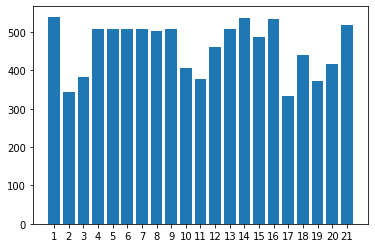

In [32]:
import matplotlib.pyplot as plt
import csv
import mod_dbconn
import joblib
import numpy as np
from flask import Flask, render_template, session
from flask import request
import requests
from bs4 import BeautifulSoup
import re
import pandas as pd
import datetime
from datetime import timedelta, date
import warnings
warnings.filterwarnings('ignore')

input_month_select = 2

csv_list = []
f = open('month_data/month_predict.csv', 'r', encoding='utf-8', newline='')
rea = csv.reader(f)
for row in rea:
    csv_list.append(row)
f.close()

month_predict_percent=list(map(int, csv_list[0]))
month_date_list=list(map(int, csv_list[1]))
start_month=list(map(int, csv_list[2]))[0]
month_change=list(map(int, csv_list[3]))
month_y_value=list(map(int, csv_list[4]))[0]

print(month_predict_percent, month_date_list)
plt.bar(month_date_list[(month_change[input_month_select-1]+1):(month_change[input_month_select]+1)], month_predict_percent[(month_change[input_month_select-1]+1):(month_change[input_month_select]+1)])
plt.xticks(month_date_list[(month_change[input_month_select-1]+1):(month_change[input_month_select]+1)], month_date_list[(month_change[input_month_select-1]+1):(month_change[input_month_select]+1)])
plt.savefig(f'static/images/month_graph{start_month+input_month_select-1}.png', dpi=100)